In [1]:
import os
import pickle
from pathlib import Path
import pickle
import re
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import h5py
import scipy
from scipy import signal
from tqdm import tnrange
from tqdm import tqdm
import seaborn as sns

from scipy.stats import norm,entropy,linregress
from scipy.optimize import minimize, curve_fit
from scipy.io import savemat
from scipy.special import erf
from sklearn.linear_model import LogisticRegression
from joblib import Parallel, delayed

#import multiprocess as mp
#from multiprocess import Pool
import sys
import warnings

from odor_breathing_functions import*

from functions_beh import*
from data_loader import*
from hdf5_loader_and_aux_functions import*


warnings.filterwarnings('ignore')

cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
modulename = 'multiprocess'
mpl.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster', font_scale=1.1)

In [9]:
all_data = df = pd.read_pickle('all_trials.pkl')


In [10]:
all_data

animal_id      date  num_trials  trial  sampling_window    type  \
0           Banner  20220323          99      0             5000  random   
1           Banner  20220323          99      1             5000  random   
2           Banner  20220323          99      2             5000  random   
3           Banner  20220323          99      3             5000  random   
4           Banner  20220323          99      4             5000  random   
...            ...       ...         ...    ...              ...     ...   
36744  Peterparker  20220212         143    138             1000   block   
36745  Peterparker  20220212         143    139             1000   block   
36746  Peterparker  20220212         143    140             1000   block   
36747  Peterparker  20220212         143    141             1000   block   
36748  Peterparker  20220212         143    142             1000   block   

       ratio                                         trial_odor  cum_odor  \
0        3.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      14.0   
1        3.0  [0.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0...      13.0   
2        3.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 100.0, 1...      13.0   
3        3.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      10.0   
4        3.0  [0.0, 0.0, 0.0, 100.0, 100.0, 100.0, 100.0, 10...      14.0   
...      ...                                                ...       ...   
36744   16.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      17.0   
36745   16.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      16.0   
36746   16.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      17.0   
36747   16.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       2.0   
36748   16.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       1.0   

       correct_trial  high_trial  low_trial  high_choice  \
0               True        True      False         True   
1               True        True      False         True   
2               True        True      False         True   
3               True        True      False         True   
4               True        True      False         True   
...              ...         ...        ...          ...   
36744           True        True      False         True   
36745           True        True      False         True   
36746           True        True      False         True   
36747          False       False       True         True   
36748          False       False      False         True   

                                              sniff_hist  \
0      [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...   
1      [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, ...   
2      [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, ...   
3      [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, ...   
4      [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...   
...                                                  ...   
36744  [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, ...   
36745  [1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...   
36746  [0.0, 0.0, 2.0, 1.0, 3.0, 1.0, 0.0, 3.0, 0.0, ...   
36747  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
36748  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     sniff_hist_shuffled  \
0      [1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...   
1      [1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
2      [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 3.0, ...   
3      [0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, ...   
4      [1.0, 0.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 0.0, ...   
...                                                  ...   
36744  [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, ...   
36745  [1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 3.0, ...   
36746  [1.0, 1.0, 1.0, 2.0, 1.0, 4.0, 2.0, 0.0, 1.0, ...   
36747  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
36748  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

        

In [4]:
cum_odor_all, _ = convert_pooled_to_array(all_data, "cum_odor", by_animal=False)
sniff_hist_all, _ = convert_pooled_to_array(all_data, "sniff_hist", by_animal=False)
sniff_hist_sh_all, _ = convert_pooled_to_array(all_data, "sniff_hist_shuffled", by_animal=False)
high_choices_all, _ = convert_pooled_to_array(all_data, "high_choices", by_animal=False)

selected_trials = np.logical_and(cum_odor_all>0,cum_odor_all<21).squeeze()
cum_odor_selected = cum_odor_all[selected_trials]
sniff_hist_selected = sniff_hist_all[selected_trials,:]
high_choices_selected = high_choices_all[selected_trials]
sniff_hist_sh_selected = sniff_hist_sh_all[selected_trials]

In [5]:
def bootstrap_worker(X, y, random_state=None):
    rng = np.random.default_rng(random_state)
    idx = rng.choice(len(y), len(y), replace=True)
    Xb, yb = X[idx], y[idx]

    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(Xb, yb)
    weights = model.coef_[0][:len(Xb)]/model.coef_[0][:len(Xb)].max()
    return weights.ravel()


def bs_logistic(
    X,
    y,
    N_bootstrap=15000,
    n_jobs=-1,
    random_seed=None,
):
    rng = np.random.default_rng(random_seed)
    seeds = rng.integers(0, 1e6, size=N_bootstrap)

    results = Parallel(n_jobs=n_jobs)(
        delayed(bootstrap_worker)(X, y, random_state=s)
        for s in seeds
    )

    all_coefs = np.vstack(results)
    mean_coefs = all_coefs.mean(axis=0)
    std_coefs = all_coefs.std(axis=0)
    ci_low = np.percentile(all_coefs, 2.5, axis=0)
    ci_high = np.percentile(all_coefs, 97.5, axis=0)

    return {
        'all_coefs': all_coefs,
        'mean': mean_coefs,
        'std_coefs': std_coefs,
        'ci_low': ci_low,
        'ci_high': ci_high,
    }

In [6]:
res = bs_logistic(sniff_hist_all, high_choices_all, N_bootstrap=15000)
res_sh = bs_logistic(sniff_hist_sh_all, high_choices_all, N_bootstrap=15000)

/Users/boero/opt/anaconda3/envs/all_behavior/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/boero/opt/anaconda3/envs/all_behavior/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/boero/opt/anaconda3/envs/all_behavior/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/boero/opt/anaconda3/envs/all_behavior/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataC

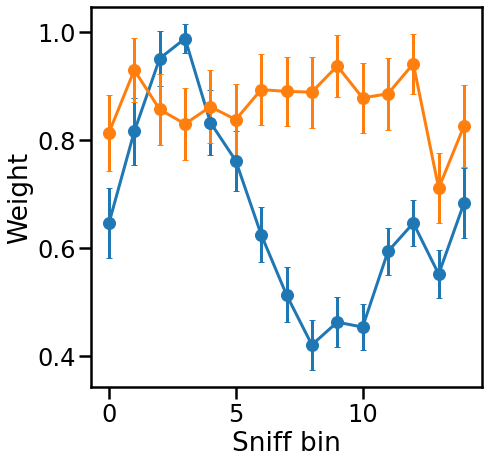

In [7]:
plt.figure(figsize=(7,7))
plt.errorbar(range(sniff_hist_all.shape[1]), res['mean'],
             yerr=res['std_coefs'],
             fmt='-o', capsize=3)
plt.errorbar(range(sniff_hist_sh_all.shape[1]), res_sh['mean'],
             yerr=res_sh['std_coefs'],
             fmt='-o', capsize=3)


plt.xlabel('Sniff bin')
plt.ylabel('Weight')
#plt.title('Bootstrapped Logistic Regression Weights')
plt.show()

Old

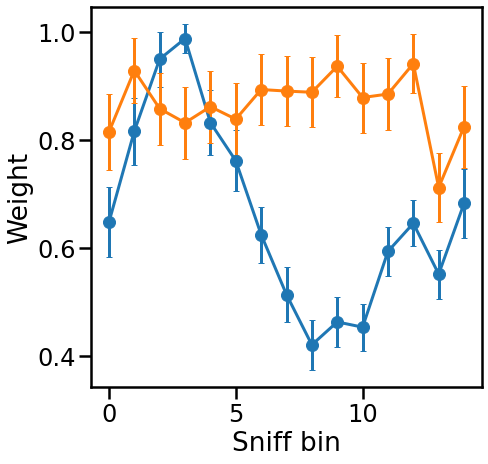

In [7]:
plt.figure(figsize=(7,7))
plt.errorbar(range(sniff_hist_all.shape[1]), res['mean'],
             yerr=res['std_coefs'],
             fmt='-o', capsize=3)
plt.errorbar(range(sniff_hist_sh_all.shape[1]), res_sh['mean'],
             yerr=res_sh['std_coefs'],
             fmt='-o', capsize=3)


plt.xlabel('Sniff bin')
plt.ylabel('Weight')
#plt.title('Bootstrapped Logistic Regression Weights')
plt.show()

In [8]:
res['mean']

array([0.6456902 , 0.81551412, 0.9504395 , 0.98746085, 0.83191901,
       0.7612323 , 0.62457731, 0.51303177, 0.42032848, 0.46248978,
       0.45329192, 0.59328354, 0.64584852, 0.55136613, 0.68299045])

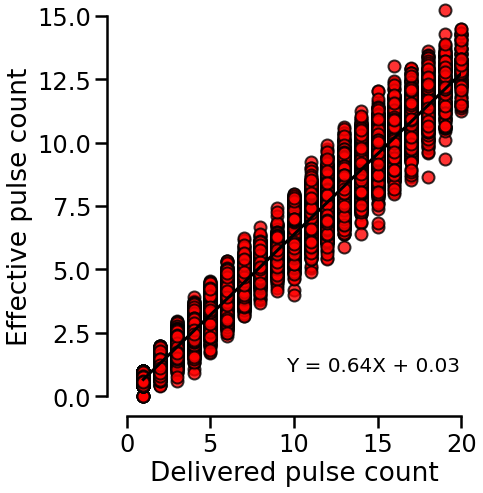

In [21]:
weighted_odor = (sniff_hist_selected*res['mean']).sum(axis=1)
slope, intercept, r_value, p_value, std_err  =  linregress(cum_odor_selected.squeeze(), weighted_odor)
x_fit = np.linspace(1,20,20)
Y_pred_new = x_fit * slope + intercept

plt.figure(figsize=(6,7))
plt.scatter(cum_odor_selected, weighted_odor, marker='o', color='r', edgecolors='k', alpha=.8, clip_on=False)#, vert=False)
plt.plot(x_fit, Y_pred_new, c='k')
equation_text = f'Y = {slope:.2f}X + {intercept:.2f}'
plt.text(9.5,1,equation_text, size=20)
plt.xlabel('Delivered pulse count')
plt.ylabel('Effective pulse count')
plt.ylim(0,15)
plt.xlim(0,20)
sns.despine(offset=20)